In [1]:
"""
Tag and categorize the historical expenses from splitwise
The expense data is cached locally in expenses.json.
The tags are stored locally in tags.json in the form of
{
  "wants": [
                str,
                    {
                      "keyword": str,
                      "comment": str,
                      "match_word": true,
                      "match_case": false,
                      "ignore_id": [list of expense id to ignore for this]
                    },
           ]
}
PS: There's no ML. Its just honest labour to categorize based on ones own thoughts
"""

'\nTag and categorize the historical expenses from splitwise\nThe expense data is cached locally in expenses.json.\nThe tags are stored locally in tags.json in the form of\n{\n  "wants": [<list of str of expense names in lower case>]\n}\nPS: There\'s no ML. Its just honest labour to categorize based on ones own thoughts\n'

In [13]:
import json
import os
from datetime import datetime, timedelta

import dotenv
import pytz
import requests
from dateutil.parser import parse

from utils import get_unique_by_key

dotenv.load_dotenv()

BASE_URL = "https://secure.splitwise.com/api/v3.0/get_expenses"
HEADERS = {"Authorization": f"Bearer {os.getenv('SPLITWISE_TOKEN')}"}


def fetch_expenses(start_date, end_date, limit=200):
    params = {
        "dated_after": start_date.isoformat() + "Z",
        "dated_before": end_date.isoformat() + "Z",
        "limit": limit,
    }
    response = requests.get(BASE_URL, headers=HEADERS, params=params)
    response.raise_for_status()  # Ensure no enigmatic errors
    return response.json()


# Embark on fetching data in monthly batches
def get_all_expenses(_start_date, _end_date):
    cached_expenses = read_from_file()
    oldest_expenses = max(cached_expenses, key=lambda x: parse(x["date"])) if len(cached_expenses) > 0 else None
    _start_date = parse(oldest_expenses["date"]) + timedelta(seconds=1) if oldest_expenses else _start_date
    _all_expenses = cached_expenses
    while _start_date <= _end_date:
        next_date = _start_date + timedelta(days=30)  # Fetch monthly
        print(f"Fetching expenses from {_start_date=} to {next_date}...")
        try:
            monthly_expenses = fetch_expenses(_start_date, next_date)
            _all_expenses.extend(monthly_expenses.get("expenses", []))
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            break
        _start_date = next_date + timedelta(seconds=1)

    return get_unique_by_key(_all_expenses, key="id")


# Save the combined mosaic to a JSON file
def save_to_file(data, filename="expenses.json"):
    data = sorted(data, key=lambda x: x["date"])
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)


# Read the verdant data back from the file
def read_from_file(filename="expenses.json"):
    with open(filename, "r") as file:
        return json.load(file)


In [ ]:
START_DATE = datetime(2022, 4, 1, tzinfo=pytz.timezone("Asia/Kolkata"))
END_DATE = datetime(2025, 5, 10, tzinfo=pytz.timezone("Asia/Kolkata"))
all_expenses = get_all_expenses(_start_date=START_DATE, _end_date=END_DATE)

In [ ]:
len(all_expenses)

In [16]:
save_to_file(all_expenses)

In [ ]:
# Verify by reading back
loaded_expenses = read_from_file()
len(loaded_expenses)

In [98]:
from dateutil import parser, tz
from typing import Optional
from requests import HTTPError

USER_ID: Optional[str] = None


def get_user_id() -> str:
    """
    Get the splitwise user id
    :return:
    """
    global USER_ID

    if USER_ID:
        return USER_ID

    url = "https://secure.splitwise.com/api/v3.0/get_current_user"

    headers = {
        'Authorization': f'Bearer {os.getenv("SPLITWISE_TOKEN")}'
    }

    response = requests.request("GET", url, headers=headers, data={})

    if response.status_code == 200:
        USER_ID = response.json()["user"]["id"]
    else:
        raise HTTPError(f'Invalid Notion response {response.status_code} {response.text}', response=response)

    return USER_ID


items = []
for item in loaded_expenses:
    created = parser.parse(item['date'])
    deleted = item['deleted_at']
    name = item['description'].strip()
    if deleted:
        continue

    if name == 'Payment':
        continue
    if name == 'Settle all balances':
        continue
    created = created.astimezone(tz.tzlocal())
    result = {
        "id": item["id"],
        "date": created.strftime("%Y-%m-%d"),
        "name": name
    }
    for user in item['users']:
        if user['user_id'] == get_user_id():
            result["cost"] = float(user['owed_share'].strip())
            items.append(result)

In [ ]:
len(items)
items[0]

In [ ]:
from collections import defaultdict

all_expense_names_count = defaultdict(int)
for item in items:
    all_expense_names_count[item['name'].lower()] += 1
dict(sorted(all_expense_names_count.items(), key=lambda item: -item[1]))

In [110]:
import re

TAG_MAPPING = None


def get_tags():
    global TAG_MAPPING

    if TAG_MAPPING:
        return TAG_MAPPING

    TAG_MAPPING = read_from_file('tags.json') or {}
    return TAG_MAPPING


def tag_expense(expense_name, _id):
    """
    Assign tags to an expense based on its name.

    Args:
        expense_name (str): The name of the expense.

    Returns:
        list: A list of tags that match the expense.
    """
    tags = []

    for tag, keywords in get_tags().items():
        char_match = [keyword for keyword in keywords if isinstance(keyword, str)]
        if any(re.search(keyword.lower(), expense_name.lower()) for keyword in char_match):
            tags.append(tag)
            continue

        # Structured matches (dict)
        for kw in [k for k in keywords if isinstance(k, dict)]:
            pattern = kw["keyword"]
            word_match = kw.get("match_word", False)
            case_sensitive = kw.get("match_case", False)
            ignore_id = kw.get("ignore_id", [])

            if _id in ignore_id:
                continue

            if not case_sensitive:
                pattern = pattern.lower()
                expense_name = expense_name.lower()

            if word_match:
                regex = rf"\b{re.escape(pattern)}\b"
            else:
                regex = re.escape(pattern)

            # print(regex, expense_name)
            if re.search(regex, expense_name):
                tags.append(tag)
                break

    return tags if tags else ["other"]
    # return tags

In [ ]:
unclassified = defaultdict(int)

for expense in items:
    tags = tag_expense(expense["name"], expense["id"])
    if not tags or tags == ["other"]:
        # print(expense)
        unclassified[expense['name']] += 1
    expense["tags"] = tags

dict(sorted(unclassified.items(), key=lambda item: -item[1]))
unclassified.keys()

In [ ]:
sorted([expense for expense in items if "parents" in expense["tags"] and expense["date"].startswith("2024-12")],
       key=lambda item: item["cost"])

In [112]:
import pandas as pd

df = pd.DataFrame(items)

# Parse dates and extract the month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df = df.explode('tags')
monthly_data = df.groupby(['month', 'tags'])['cost'].sum().reset_index()
pivot_data = monthly_data.pivot(index='month', columns='tags', values='cost').fillna(0)
pivot_data

tags,eating out,fitness,growth,help others,ignore,needs,other,parents,trip,wants
month,,,,,,,,,,
2022-04,3814.81,199.00,0.0,0.00,50000.0,27480.74,0.00,0.0,2402.18,4729.01
2022-05,1333.67,0.00,0.0,0.00,0.0,24540.65,39.00,0.0,2223.87,2916.39
2022-06,1854.50,0.00,0.0,0.00,150.0,13772.33,0.00,0.0,2313.60,1596.00
2022-07,1494.50,0.00,0.0,0.00,0.0,12147.99,0.00,0.0,1721.37,1613.40
2022-08,2377.00,682.50,0.0,0.00,0.0,14189.82,0.00,0.0,255.00,611.33
2022-09,1232.67,0.00,0.0,0.00,100.0,13109.49,0.00,0.0,6159.36,468.16
2022-10,3156.67,0.00,0.0,0.00,0.0,16068.99,5.00,0.0,4869.34,5498.34
2022-11,817.50,0.00,0.0,10.00,300000.0,15792.54,0.00,0.0,309.67,300.00
2022-12,1261.79,0.00,0.0,0.00,719.0,27046.64,0.00,0.0,356.50,425.50


In [117]:
import matplotlib.pyplot as plt
import numpy as np

pivot_data.drop(columns=['other', 'ignore'], inplace=True)
# Calculate the 95th percentile for all data and cap values above the threshold
threshold = np.quantile(pivot_data.values.flatten(), 0.95)
capped_data = pivot_data.clip(upper=threshold)

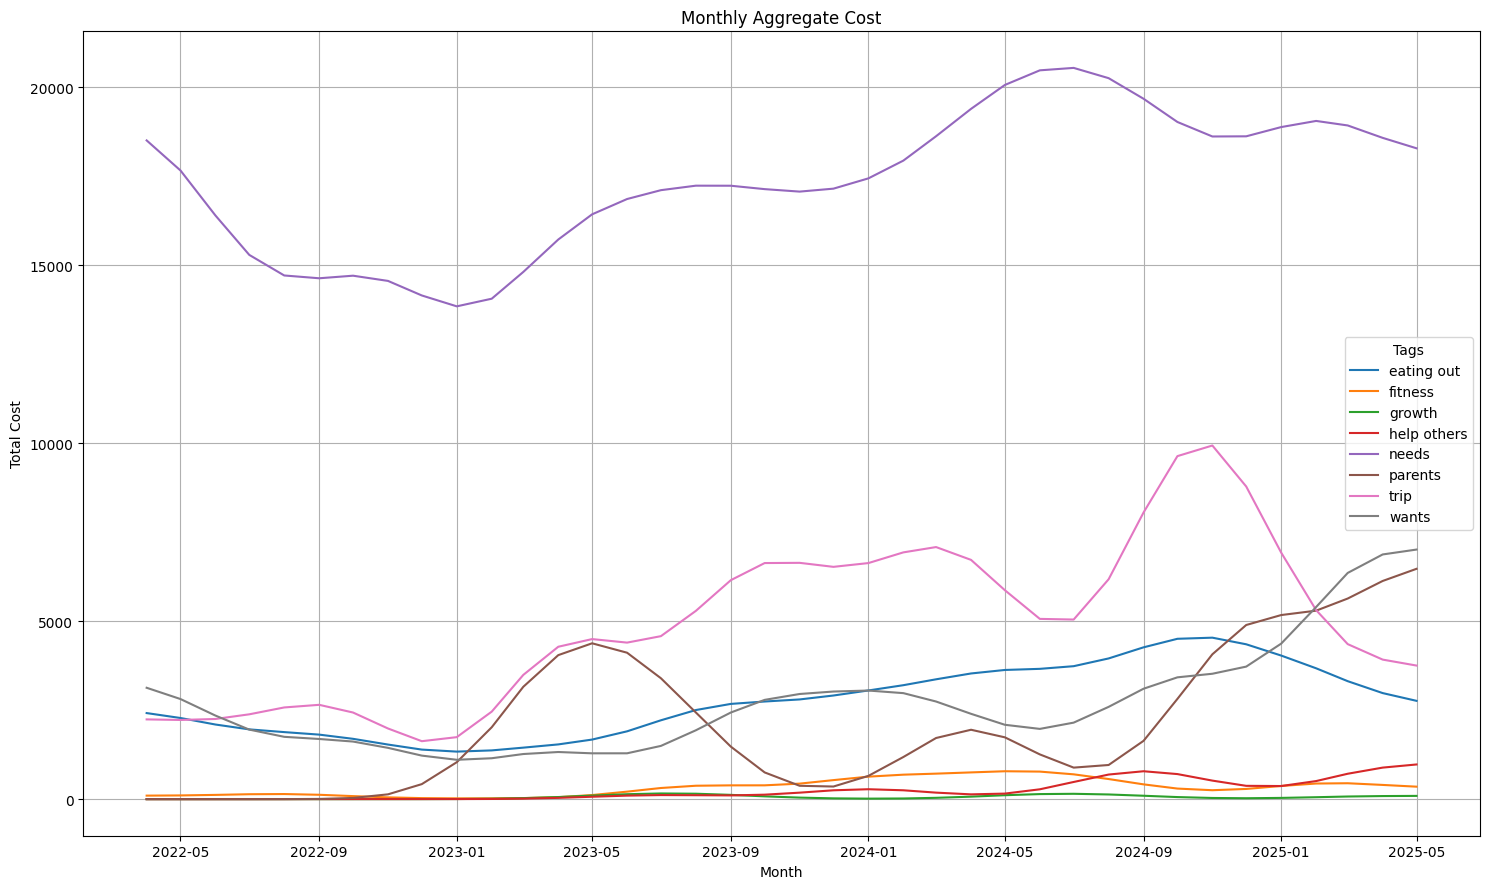

In [118]:
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(15, 9))

for tag in capped_data.columns:
    # Apply Gaussian smoothing to emulate smooth curves
    smoothed_y = gaussian_filter1d(capped_data[tag], sigma=2)

    # Plot the smoothed data
    plt.plot(capped_data.index.to_timestamp(), smoothed_y, label=tag)

plt.title('Monthly Aggregate Cost')
plt.xlabel('Month')
plt.ylabel('Total Cost')
plt.legend(title='Tags')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
capped_data